In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.integrate as integ
from scipy.spatial import Delaunay
from scipy.integrate import dblquad
import matplotlib.tri as mtri

from plot_triangulation import plot_triangle, plot_mesh
from fem2d_utils import *

# Cuadratura en dos dimensiones

## Ejercicio 1: integrales de funciones de dos variables con `dblquad`

La función `dblquad` permite hacer integrales sobre regiones simples, donde la variable `x` se mueve entre `a` y `b`, y la variable `y` se mueve entre una función inferior `g` y otra superior `h`:

$$
R=\{(x,y):\:a\leq x\leq b,\;g(x)\leq y \leq h(x)\}
$$

![simple region](simple_region.png)


 - Aprende a usar `dblquad` para integrar `f(x,y)=x*y**2` en el cuadrado `[0,2]x[0,1]`.
 - Aprende a usar `dblquad` para integrar la misma función, en el triángulo con vértices `[0,0]`, `[1,0]` y `[1,1]`, usando.
 - Aprende a usar `dblquad` para integrar la misma función, en el triángulo con vértices `[0,0]`, `[1,-1]` y `[2,0]`.

In [2]:
dblquad?

 - Aprende a usar `dblquad` para integrar `f(x,y)=x*y**2` en el cuadrado `[0,2]x[0,1]`.

> - Es exactamente el ejemplo de la documentación de dblquad (Recuerda siempre [RTFM](https://en.wikipedia.org/wiki/RTFM)).
> - Observa que los argumentos de `f` van en el orden inverso al habitual, primero la `y`, luego la `x`:

In [3]:
from scipy import integrate
f = lambda y, x: x*y**2
integrate.dblquad(f, 0, 2, lambda x: 0, lambda x: 1)


(0.6666666666666667, 7.401486830834377e-15)

 - Aprende a usar `dblquad` para integrar la misma función, en el triángulo con vértices `[0,0]`, `[1,0]` y `[1,1]`, usando.

> - Se trata de una región simple, donde x se mueve entre 0 y 1, la función inferior es constantemente 0, y la superior es h(x)=x

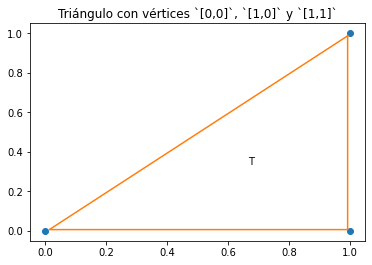

In [58]:
plt.title('Triángulo con vértices `[0,0]`, `[1,0]` y `[1,1]`')
vs2 = np.array([
    [0,0],
    [1,0],
    [1,1]
])
plot_triangle(vs2)

In [5]:
from scipy import integrate
def integrando(y,x):
    return x*y**2
def g(x):
    return 0
def h(x):
    return x
integrate.dblquad(integrando, 0, 1, lambda x: 0, lambda x: x)


(0.06666666666666668, 3.6687045085928234e-15)

 - Aprende a usar `dblquad` para integrar la misma función, en el triángulo con vértices `[0,0]`, `[1,-1]` y `[2,0]`.
> - Esta región se puede descomponer en dos, pero no es necesario. También es una región simple, donde x se mueve entre 0 y 2, la función superior es constantemente 0, y la inferior es g(x)=max(-x, x-2)

Text(0.5, 1.0, 'triángulo con vértices `[0,0]`, `[1,-1]` y `[2,0]`')

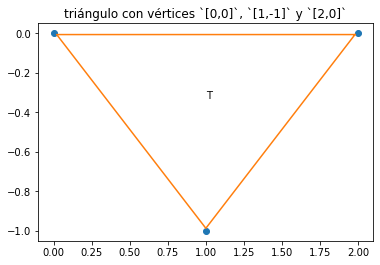

In [56]:
vs2 = np.array([
    [0,0],
    [1,-1],
    [2,0]
])
plot_triangle(vs2)
plt.title('triángulo con vértices `[0,0]`, `[1,-1]` y `[2,0]`')

In [7]:
from scipy import integrate
def integrando(y,x):
    return x*y**2
def g(x):
    return max(-x, x-2)
def h(x):
    return 0
integrate.dblquad(integrando, 0, 1, g, h)

(0.06666666666666668, 3.6687045085928234e-15)

- Extra: calcula el área de un círculo de radio 1
> Integramos la función 1 en el círculo unidad, que es una región simple, donde x se mueve entre  -1 y 1, definida por la función inferior $-\sqrt{1-x^2}$ y $\sqrt{1-x^2}$.

In [8]:
from scipy import integrate
def integrando(y,x):
    return 1
def g(x):
    return -np.sqrt(1-x**2)
def h(x):
    return np.sqrt(1-x**2)
integrate.dblquad(integrando, -1, 1, g, h)

(3.1415926535897967, 2.000470900043183e-09)

## Ejercicio 2: Cuadratura en triángulos

El sistema anterior tiene una dificultad práctica: si nos dan los vértices del triángulo, a veces tenemos que usar la función superior, a veces la inferior, y escribir las funciones a mano. Una solución es hacer un cambio de variable para llevar el triángulo a un triángulo de referencia. Otra solución más sencilla de implementar es usar un método de cuadratura para triángulos. Además, para el método de elementos finitos, no necesitamos hacer integrales muy precisas sobre los triángulos, porque nuestro método tendrá error de truncamiento del orden de una potencia del mayor diámetro de un triángulo. Si queremos más precisión, podemos usar reglas compuestas sobre una triangulación más fina:

 - Busca en el código de elementos finitos código para calcular el área de un triángulo, conocidos los vértices.
 - Implementa la 'regla del centroide': se aproxima la integral por el área del triángulo multiplicada por el valor de la función en el baricentro del triángulo.
 - Implementa la 'regla de los vértices': se aproxima la integral por el área del triángulo multiplicada por el promedio de la función en los vértices del triángulo.
 - Implementa la 'regla de los puntos medios': se aproxima la integral por el área del triángulo multiplicada por el promedio de la función en los puntos medios de los lados del triángulo.
 - Comprueba para las funciones de abajo, qué métodos las integran exactamente
 - ¿Cuál parece ser el grado de exactitud de cada regla?

In [60]:
def area_triangulo(vs):
    # Construye la transformación afín que lleva (1,0), (0,1), (0,0) a los vértices del triángulo
    # Una transformación afín P multiplica las áreas por det(P)
    P = np.ones((3,3))
    P[:,:2] = vs
    area = la.det(P)/2
    return abs(area)

In [61]:
vs = np.array([
    [0,0],
    [1,0],
    [0,1]
])
area_triangulo(vs)

0.5

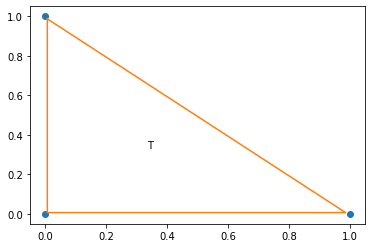

In [65]:
plot_triangle(vs)

In [79]:
def quad_baricentro(vs, f):
    baricentro = vs.sum(axis=0)/3
    return area_triangulo(vs)*f(baricentro)

def quad_vertices(vs, f):
    fv1, fv2, fv3 = f(vs[0,:]), f(vs[1,:]), f(vs[2,:])
    return area_triangulo(vs)*(fv1 + fv2 + fv3)/3

def quad_puntos_medios(vs, f):
    v1,v2,v3 = vs[0],vs[1],vs[2]
    fmid12, fmid23, fmid31 = f((v1+v2)/2), f((v2+v3)/2), f((v3+v1)/2)
    return area_triangulo(vs)*(fmid12 + fmid23 + fmid31)/3

def f_const(xy):
    return 1
def f_lin  (xy):
    return xy[0] + xy[1]
def f_cuad (xy):
    return xy[0]*xy[1]
def f_cub  (xy):
    return xy[0]*xy[1]**2 + xy[1]**3
test_funs = [
    f_const, f_lin, f_cuad, f_cub
]
integrales = [
    # Invertimos los argumentos del integrando porque dblquad es así :-/
    dblquad(lambda y,x: f([x,y]), 0, 1, lambda x:0, lambda x:1-x)[0]
    for f in test_funs
]

In [80]:
for quad_fun in [quad_baricentro, quad_vertices, quad_puntos_medios]:
    print('#'*3,quad_fun.__name__)
    for f, int_f in zip(test_funs, integrales):
        print('#'*6, f.__name__, ':',quad_fun(vs, f), '. Integral exacta =',int_f)

### quad_baricentro
###### f_const : 0.5 . Integral exacta = 0.5
###### f_lin : 0.3333333333333333 . Integral exacta = 0.3333333333333333
###### f_cuad : 0.05555555555555555 . Integral exacta = 0.04166666666666667
###### f_cub : 0.037037037037037035 . Integral exacta = 0.06666666666666668
### quad_vertices
###### f_const : 0.5 . Integral exacta = 0.5
###### f_lin : 0.3333333333333333 . Integral exacta = 0.3333333333333333
###### f_cuad : 0.0 . Integral exacta = 0.04166666666666667
###### f_cub : 0.16666666666666666 . Integral exacta = 0.06666666666666668
### quad_puntos_medios
###### f_const : 0.5 . Integral exacta = 0.5
###### f_lin : 0.3333333333333333 . Integral exacta = 0.3333333333333333
###### f_cuad : 0.041666666666666664 . Integral exacta = 0.04166666666666667
###### f_cub : 0.0625 . Integral exacta = 0.06666666666666668


> Deducimos, de su fallo al integrar polinomios de grado alto, que los grados de exactitud de cada regla son:
> - baricentro: <= 1
> - vértices: <= 1
> - puntos medios: <= 2

> No podemos asegurar cuáles son los grados de exactitud con esta información, pero parece que son (ya que integran correctamente _algunos_ polinomios de ese grado):
> - baricentro: 1
> - vértices: 1
> - puntos medios: 2

> Lo podemos _demostrar_ ampliando la base de funciones de prueba hasta _una base de los polinomios de grado 2_

In [68]:
def f_const(xy):
    return 1
def f_lin1  (xy):
    return xy[0]
def f_lin2  (xy):
    return xy[1]
def f_cuad1 (xy):
    return xy[0]**2
def f_cuad2 (xy):
    return xy[0]*xy[1]
def f_cuad3 (xy):
    return xy[1]**2
base_funs_2 = [
    f_const, f_lin1, f_lin2, f_cuad1, f_cuad2, f_cuad3
]
integrales_base = [
    # Invertimos los argumentos del integrando porque dblquad es así :-/
    dblquad(lambda y,x: f([x,y]), 0, 1, lambda x:0, lambda x:1-x)[0]
    for f in base_funs_2
]
for quad_fun in [quad_baricentro, quad_vertices, quad_puntos_medios]:
    print('#'*3,quad_fun.__name__)
    for f, int_f in zip(test_funs, integrales_base):
        print('#'*6, f.__name__, ':',quad_fun(vs, f), '. Integral exacta =',int_f)

### quad_baricentro
###### f_const : 0.5 . Integral exacta = 0.5
###### f_lin : 0.3333333333333333 . Integral exacta = 0.16666666666666669
###### f_cuad : 0.05555555555555555 . Integral exacta = 0.16666666666666669
###### f_cub : 0.037037037037037035 . Integral exacta = 0.08333333333333334
### quad_vertices
###### f_const : 0.5 . Integral exacta = 0.5
###### f_lin : 0.3333333333333333 . Integral exacta = 0.16666666666666669
###### f_cuad : 0.0 . Integral exacta = 0.16666666666666669
###### f_cub : 0.16666666666666666 . Integral exacta = 0.08333333333333334
### quad_puntos_medios
###### f_const : 0.5 . Integral exacta = 0.5
###### f_lin : 0.3333333333333333 . Integral exacta = 0.16666666666666669
###### f_cuad : 0.041666666666666664 . Integral exacta = 0.16666666666666669
###### f_cub : 0.0625 . Integral exacta = 0.08333333333333334


## Ejercicio 3

Implementa la regla de cuadratura de los vértices compuesta, usando una triangulación de un dominio.

> Una triangulación de ejemplo:

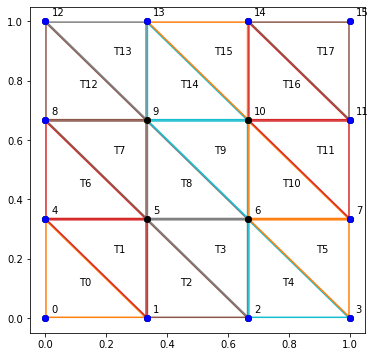

In [105]:
vertices, ivertices_boundary, triangles = square_mesh(3, L=1)
plt.figure(figsize=(6,6))
plot_mesh(vertices,ivertices_boundary,triangles)

> - Para implementar la regla compuesta, sólo hay que sumar la regla simple sobre cada triángulo (se puede hacer más eficiente, pero nos conformamos con esta implementación, más sencilla).

In [106]:
def quad_vertices_compuesta(vertices, triangles, f):
    return sum(quad_vertices(vertices[triangle], f)
               for triangle in triangles)

integrales = [
    dblquad(lambda y,x: f([x,y]), 0, 1, lambda x:0, lambda x:1)[0]
    for f in test_funs
]

for f, int_f in zip(test_funs, integrales):
    print(f.__name__, ':',quad_vertices_compuesta(vertices, triangles, f), '. Integral exacta =',int_f)

f_const : 1.0000000000000002 . Integral exacta = 1.0
f_lin : 0.9999999999999999 . Integral exacta = 1.0
f_cuad : 0.24074074074074078 . Integral exacta = 0.24999999999999997
f_cub : 0.4444444444444444 . Integral exacta = 0.41666666666666663
f_cub2 : 0.7222222222222222 . Integral exacta = 0.6666666666666667


> - Repetimos para la regla de los puntos medios, y nos encontramos con la sorpresa de que integra de forma exacta (salvo error numérico) el polinomio cúbico de prueba. Si probáis otros polinomios cúbicos, veréis que la regla también los integra de forma exacta :-O...

In [107]:
def quad_puntos_medios_compuesta(vertices, triangles, f):
    return sum(quad_puntos_medios(vertices[triangle], f)
              for triangle in triangles)

for f, int_f in zip(test_funs, integrales):
    print(f.__name__, ':',quad_puntos_medios_compuesta(vertices, triangles, f), '. Integral exacta =',int_f)

f_const : 1.0000000000000002 . Integral exacta = 1.0
f_lin : 0.9999999999999999 . Integral exacta = 1.0
f_cuad : 0.25 . Integral exacta = 0.24999999999999997
f_cub : 0.4166666666666666 . Integral exacta = 0.41666666666666663
f_cub2 : 0.6666666666666665 . Integral exacta = 0.6666666666666667


> - Pero es una casualidad que sólo ocurre al integrar sobre un cuadrado. Sobre otro dominio, la regla compuesta no es exacta...

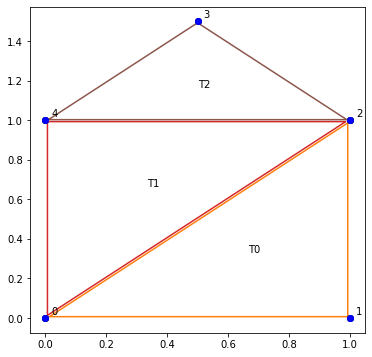

In [108]:
vertices = np.array([
    [0,0],
    [1,0],
    [1,1],
    [1/2,3/2],
    [0,1]
])
ivertices_boundary = np.arange(5)

triangles = np.array([
    [0,1,2],
    [0,2,4],
    [2,3,4]
])

plt.figure(figsize=(6,6))
plot_mesh(vertices, ivertices_boundary, triangles)

In [109]:
def f_const(xy):
    return 1
def f_lin  (xy):
    return xy[0] + xy[1]
def f_cuad (xy):
    return xy[0]*xy[1]
def f_cub  (xy):
    return xy[0]*xy[1]**2 + xy[1]**3
def f_cub2  (xy):
    return xy[0]*xy[1]**2 + 2*xy[1]**3
test_funs = [
    f_const, f_lin, f_cuad, f_cub, f_cub2
]
integrales = [
    dblquad(lambda y,x: f([x,y]), 0, 1, lambda x:0, lambda x:min(1+x,2-x))[0]
    for f in test_funs
]

In [110]:
for f, int_f in zip(test_funs, integrales):
    print(f.__name__, ':',quad_puntos_medios_compuesta(vertices, triangles, f), '. Integral exacta =',int_f)

f_const : 1.25 . Integral exacta = 1.25
f_lin : 1.4166666666666667 . Integral exacta = 1.4166666666666667
f_cuad : 0.39583333333333337 . Integral exacta = 0.3958333333333333
f_cub : 0.9973958333333333 . Integral exacta = 0.9979166666666666
f_cub2 : 1.65625 . Integral exacta = 1.6572916666666666


> - y la aproximación mejora, pero sigue sin ser exacta, aunque refinemos la triangulación:

In [111]:
nrefines = 3
for n in range(nrefines):
    print('refine:', n+1)
    vertices, ivertices_boundary, triangles = refine_mesh(vertices, ivertices_boundary, triangles)
    for f, int_f in zip(test_funs, integrales):
        print(f.__name__, ':',quad_puntos_medios_compuesta(vertices, triangles, f), '. Integral exacta =',int_f)

refine: 1
f_const : 1.25 . Integral exacta = 1.25
f_lin : 1.4166666666666667 . Integral exacta = 1.4166666666666667
f_cuad : 0.3958333333333334 . Integral exacta = 0.3958333333333333
f_cub : 0.9977936921296298 . Integral exacta = 0.9979166666666666
f_cub2 : 1.6569974922839508 . Integral exacta = 1.6572916666666666
refine: 2
f_const : 1.2499999999999996 . Integral exacta = 1.25
f_lin : 1.4166666666666665 . Integral exacta = 1.4166666666666667
f_cuad : 0.3958333333333333 . Integral exacta = 0.3958333333333333
f_cub : 0.9979423713267396 . Integral exacta = 0.9979166666666666
f_cub2 : 1.6573391983023693 . Integral exacta = 1.6572916666666666
refine: 3
f_const : 1.2499999999999998 . Integral exacta = 1.25
f_lin : 1.4166666666666652 . Integral exacta = 1.4166666666666667
f_cuad : 0.39583333333333326 . Integral exacta = 0.3958333333333333
f_cub : 0.9979157266059678 . Integral exacta = 0.9979166666666666
f_cub2 : 1.6572900510450228 . Integral exacta = 1.6572916666666666
